# Copilot - driving assistance
## Lane and obstacle detection for active assistance during driving.

Imagine having a momentary loss of attention while driving down a highway, and immediately you hone letting off a auditory warning alerting you before you come too close to the vehicle infront. If you are overspeeding a message nudges you to slowdown. After you complete the drive you can see a summary of how safe or rash you have driven during this trip.


![alt text](https://github.com/visualbuffer/copilot/raw/master/images/assets/Top-View.gif)

This notebook runs through the code available at  https://github.com/visualbuffer/copilot . It uses pytube library which allows it to download and subsequently process you tube videos.

There will be three steps we will first download all the dependencies, second set up the parameters for processing and finally process a stream of video. Our objective is to get to a real time or better processing speed. 

So onto the first step downloading and instaqlling all the dependencies.

In [0]:
# ! rm -r copilot
# !rm -r images
# !rm -r utils
# !rm -r font
# !rm -r keras-yolo3-master/
# !rm -r keras-yolo3-queee/
# !rm -r model_data
# !rm -r videos
# !rm -r zoo
! git clone https://github.com/visualbuffer/copilot.git
! mv copilot/* ./
! mkdir videos
! mkdir images
! mkdir images/from_video
! mkdir images/detection
# ! wget  -P ./model_data/  https://pjreddie.com/media/files/yolov3.weights
! wget -P ./model_data/ https://s3-ap-southeast-1.amazonaws.com/deeplearning-mat/backend.h5
!pip install git+git://github.com/minwook-shin/pytube --force

rm: cannot remove 'keras-yolo3-master/': No such file or directory
rm: cannot remove 'keras-yolo3-queee/': No such file or directory
Cloning into 'copilot'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 467 (delta 47), reused 71 (delta 22), pack-reused 363
Receiving objects: 100% (467/467), 14.93 MiB | 8.81 MiB/s, done.
Resolving deltas: 100% (256/256), done.
mkdir: cannot create directory ‘images’: File exists
--2019-08-29 17:08:19--  https://s3-ap-southeast-1.amazonaws.com/deeplearning-mat/backend.h5
Resolving s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)... 52.219.36.170
Connecting to s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)|52.219.36.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248671664 (237M) [application/x-www-form-urlencoded]
Saving to: ‘./model_data/backend.h5’

backend.h5          100%[========

## Dependencies
We will import the dependencies and set up a helper function to extract youtube videos.

In [0]:
from pytube import YouTube 
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [0]:
def download_file(link, file) :
  video = "./videos/" #to_do 
  yt = YouTube(link)   
  yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').first().download(output_path=video, filename=str(file))

  print(link, ' Downloaded to ',video+ str(file))

  return video+ str(file)+".mp4"

In [0]:
download_file("https://www.youtube.com/watch?reload=9&v=rT0TQmxxeeE","electronic_city")
download_file("https://www.youtube.com/watch?v=b8iR1rcDxi4","nice_road")
download_file("https://www.youtube.com/watch?v=-SHw5gkB9Ow&list=PLvdT8C0jlPY0uFs8Ogh8Hb1FVvRe3DLj9","nh60")

https://www.youtube.com/watch?reload=9&v=rT0TQmxxeeE  Downloaded to  ./videos/electronic_city
https://www.youtube.com/watch?v=b8iR1rcDxi4  Downloaded to  ./videos/nice_road
https://www.youtube.com/watch?v=-SHw5gkB9Ow&list=PLvdT8C0jlPY0uFs8Ogh8Hb1FVvRe3DLj9  Downloaded to  ./videos/nh60


'./videos/nh60.mp4'

## Initiate the parameters

In this step we will evaluate the parameters and check if they are optimal. Each camere as slightly different sensetivity so a universal threshold will not work. However once set for a given camera it should be good enough. Similary dash cams are mounted in different position some tweaks might be required for the same.

Check the masked images they should pick up the lanes avoid the road and foilage. If not adjust the parameters a bit. Finally check if the horizon / vanishing point is being picked correctly. Normally we would supply a frame from the video which contains a straight set of the road for determining the position.

![alt text](https://github.com/visualbuffer/copilot/raw/master/images/assets/Slide4.PNG)




Using TensorFlow backend.


PERSPECTIVE TRANSFORMATION MATRIX COMPUTED


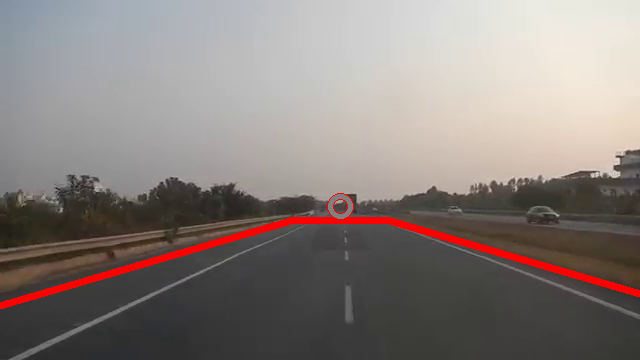

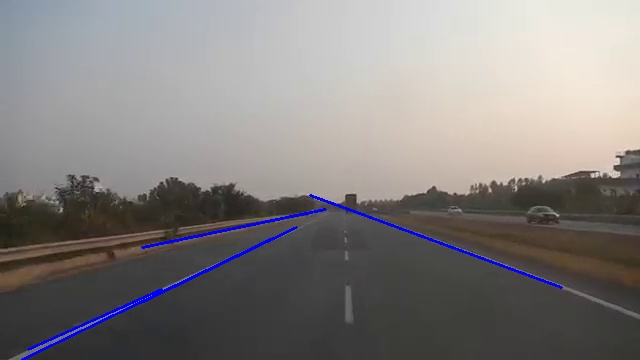

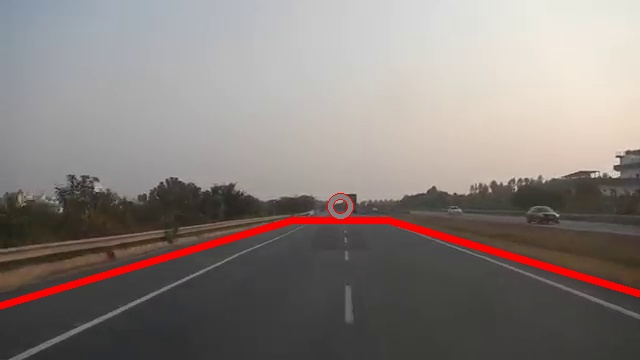

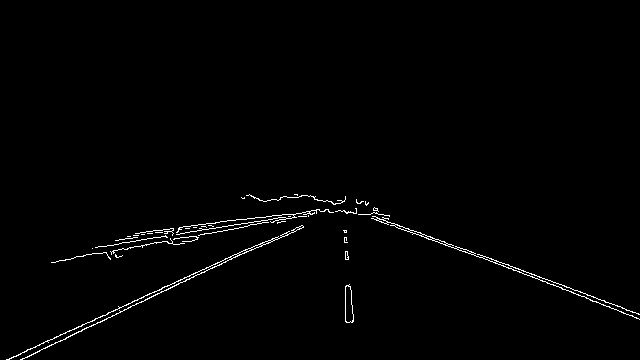

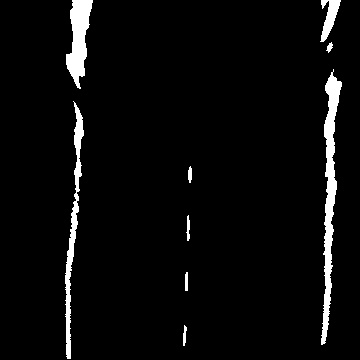

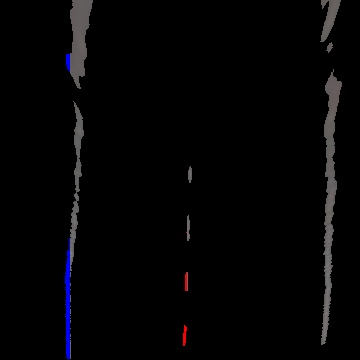

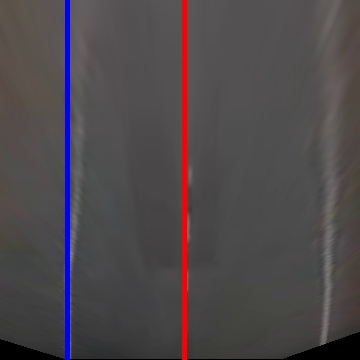

In [0]:
from lane_detection import LANE_DETECTION
video_reader =  cv2.VideoCapture("./videos/nice_road.mp4") 
fps =  video_reader.get(cv2.CAP_PROP_FPS)
nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
pers_frame_time = 398# seconds
pers_frame = int(pers_frame_time *fps)
video_reader.set(1,pers_frame)
ret, image = video_reader.read()
ld = LANE_DETECTION( image,fps, 
                    yellow_lower = np.uint8([ 20, 50,   110]),
                    yellow_upper = np.uint8([35, 255, 255]),
                    white_lower = np.uint8([ 0, 140,   0]), 
                    white_upper = np.uint8([255, 255, 100]), 
                    lum_factor = 110,
                    lane_start=[0.2,0.5])
cv2_imshow(image)

cv2_imshow(cv2.imread("./images/detection/perspective_lines.jpg"))
cv2_imshow(cv2.imread("./images/detection/vanishing_point.jpg"))
cv2_imshow(cv2.imread("./images/detection/edges.jpg"))
cv2_imshow(cv2.imread("./images/detection/mask.jpg"))
cv2_imshow(cv2.imread("./images/detection/masked_regions.jpg"))
cv2_imshow(cv2.imread("./images/detection/lane_width.jpg"))







# proc_img = ld.process_image(image)
# cv2_imshow(proc_img)


## Processing frames

Once you are happy with the parameters we will supply them to the frame class method and have it process the video

### List of parameters

| PARAMETER  | Description |
| ------------- | ------------- |
|SELF VEHICLE OFFSET| Trim off from bottom edge video if ego vehicle covers part of the frame % of front view|
| LOWER YELLOW HLS THRESHOLD  | Lower yellow HLS threshold used to prepare the mask. Tune down if yellow lane is not detected, up if all the foilage is  |
| UPPER YELLOW HLS THRESHOLD | Upper threshold for identifying yellow lanes |
|LOWER WHITE THRESHOLD| Lower yellow HLS threshold used to prepare the mask. Tune up  saturation if  foilage lights up the entire scene  |
|UPPER WHITE THRESHOLD| |
|NORMALIZING LUM FACTOR| Factor used to normalize luminosity against, reducing increses lower Lum threshold |
|MAX GAP THRESHOLD| Max continous gap tollerated in the lane detection % of top-view height |
|YOLO PERIOD| Period [s] after which YOLO is detected, typ 2s reducing decreases processing fps increases detection|
|LANE INITIATION| intial guess for lane start % of top-view width|
|VERBOSITY|1 Show lesser,2 Show less,3 Show everything |


```python

#frame.process_video( input location , frame rate reduction factor
#        save location, perspective computed at time
#        start time , end time for processing [s])

```

This is set to about 1000 secs about 15 mins. Change t1 if you need to reduce processing duration

In [0]:
from frame import FRAME

file_path =  "./videos/nice_road.mp4"# <== Upload appropriate file          
video_out = "videos/output11.mov"
frame =  FRAME( 
    ego_vehicle_offset = .0,                       # offset for self vehicle in frame
    yellow_lower = np.uint8([ 20, 50,   110]),      # LOWER YELLOW HLS THRESHOLD
    yellow_upper = np.uint8([35, 255, 255]),        # UPER YELLOW HLS THRESHOLD
    white_lower = np.uint8([ 0, 140,   0]),         # LOWER WHITE THRESHOLD
    white_upper = np.uint8([180, 255, 100]),        # UPPER WHITE THRESHOLD
    lum_factor = 110,                               # NORMALIZING LUM FACTOR
    max_gap_th = 0.45,                              # MAX GAP THRESHOLD
    YOLO_PERIOD = 2,                              # YOLO PERIOD
    lane_start=[0.2,0.5] ,                        # LANE INITIATION
    verbose = 3)                                  # VERBOSITY
frame.process_video(file_path, 2,\
        video_out = video_out,pers_frame_time =398,\
        t0  =398 , t1 =698)#None)                  

W0829 17:09:08.895091 140056742709120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0829 17:09:08.905669 140056742709120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0829 17:09:08.908379 140056742709120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0829 17:09:09.023953 140056742709120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0829 17:09:09.024703 1400567427

./videos/nice_road.mp4 WIDTH 640 HEIGHT 360 FPS 29.97 DUR 1686.0 s
PERSPECTIVE TRANSFORMATION MATRIX COMPUTED


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 1/8991 [00:03<8:36:40,  3.45s/it]


LANE CHANGE TO RIGHT

LANE CHANGE TO LEFT


  2%|▏         | 193/8991 [00:06<5:54:39,  2.42s/it]


LANE CHANGE TO RIGHT


  7%|▋         | 635/8991 [00:12<2:46:01,  1.19s/it]


LANE CHANGE TO LEFT
SKIPPED 23% BREACHED 5% RESET 1% APPENDED 70% | Time 24s , Processing FPS 17.50 vs Desired FPS 14.00  


 12%|█▏        | 1123/8991 [00:18<1:17:25,  1.69it/s]


LANE CHANGE TO LEFT

LANE CHANGE TO RIGHT


 17%|█▋        | 1525/8991 [00:24<36:57,  3.37it/s]

SKIPPED 15% BREACHED 2% RESET 0% APPENDED 81% | Time 11s , Processing FPS 38.18 vs Desired FPS 14.00  


 20%|█▉        | 1775/8991 [00:27<25:26,  4.73it/s]


LANE CHANGE TO RIGHT


 22%|██▏       | 2003/8991 [00:30<17:42,  6.58it/s]


LANE CHANGE TO RIGHT


 27%|██▋       | 2414/8991 [00:38<09:11, 11.93it/s]

SKIPPED 17% BREACHED 4% RESET 0% APPENDED 76% | Time 13s , Processing FPS 32.31 vs Desired FPS 14.00  


 31%|███       | 2804/8991 [00:45<05:14, 19.68it/s]


LANE CHANGE TO RIGHT


 37%|███▋      | 3313/8991 [00:56<02:55, 32.31it/s]

SKIPPED 56% BREACHED 4% RESET 0% APPENDED 38% | Time 17s , Processing FPS 24.71 vs Desired FPS 14.00  

LANE CHANGE TO LEFT

LANE CHANGE TO RIGHT

LANE CHANGE TO LEFT


 39%|███▉      | 3497/8991 [00:59<02:26, 37.62it/s]


LANE CHANGE TO RIGHT

LANE CHANGE TO LEFT

LANE CHANGE TO RIGHT


 41%|████      | 3675/8991 [01:02<02:05, 42.20it/s]/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)



LANE CHANGE TO LEFT


 43%|████▎     | 3847/8991 [01:05<01:52, 45.80it/s]


LANE CHANGE TO LEFT

LANE CHANGE TO RIGHT


 45%|████▍     | 4023/8991 [01:08<01:41, 48.94it/s]


LANE CHANGE TO LEFT

LANE CHANGE TO RIGHT

LANE CHANGE TO RIGHT

LANE CHANGE TO LEFT


 47%|████▋     | 4195/8991 [01:11<01:37, 49.38it/s]


LANE CHANGE TO LEFT
SKIPPED 33% BREACHED 16% RESET 3% APPENDED 47% | Time 14s , Processing FPS 30.00 vs Desired FPS 14.00  

LANE CHANGE TO RIGHT

LANE CHANGE TO RIGHT


 49%|████▊     | 4361/8991 [01:16<01:43, 44.72it/s]


LANE CHANGE TO LEFT


 53%|█████▎    | 4801/8991 [01:22<01:15, 55.78it/s]


GOT EXEPTION TO PROCES THE IMAGE 2438

GOT EXEPTION TO PROCES THE IMAGE 2469

LANE CHANGE TO LEFT


 55%|█████▌    | 4986/8991 [01:25<01:09, 57.37it/s]

SKIPPED 29% BREACHED 7% RESET 1% APPENDED 61% | Time 14s , Processing FPS 30.00 vs Desired FPS 14.00  

LANE CHANGE TO RIGHT


 64%|██████▍   | 5780/8991 [01:39<01:01, 52.48it/s]


LANE CHANGE TO RIGHT

GOT EXEPTION TO PROCES THE IMAGE 2913

LANE CHANGE TO LEFT

LANE CHANGE TO RIGHT
SKIPPED 32% BREACHED 8% RESET 0% APPENDED 57% | Time 16s , Processing FPS 26.25 vs Desired FPS 14.00  

LANE CHANGE TO LEFT


 66%|██████▌   | 5946/8991 [01:44<01:08, 44.37it/s]


LANE CHANGE TO RIGHT


 68%|██████▊   | 6135/8991 [01:47<00:58, 48.64it/s]


LANE CHANGE TO LEFT

LANE CHANGE TO RIGHT

LANE CHANGE TO LEFT

LANE CHANGE TO RIGHT

GOT EXEPTION TO PROCES THE IMAGE 3100

GOT EXEPTION TO PROCES THE IMAGE 3102

GOT EXEPTION TO PROCES THE IMAGE 3103

LANE CHANGE TO LEFT

LANE CHANGE TO LEFT


 70%|███████   | 6319/8991 [01:50<00:51, 51.83it/s]


LANE CHANGE TO RIGHT


 72%|███████▏  | 6491/8991 [01:53<00:46, 53.30it/s]


LANE CHANGE TO RIGHT

GOT EXEPTION TO PROCES THE IMAGE 3287


 74%|███████▍  | 6659/8991 [01:57<00:46, 49.84it/s]

SKIPPED 35% BREACHED 19% RESET 2% APPENDED 41% | Time 15s , Processing FPS 28.00 vs Desired FPS 14.00  


 78%|███████▊  | 7017/8991 [02:03<00:36, 54.09it/s]


LANE CHANGE TO LEFT


 81%|████████  | 7265/8991 [02:06<00:28, 60.34it/s]

SKIPPED 68% BREACHED 2% RESET 0% APPENDED 28% | Time 10s , Processing FPS 42.00 vs Desired FPS 14.00  


 84%|████████▍ | 7572/8991 [02:09<00:20, 68.81it/s]


LANE CHANGE TO RIGHT

LANE CHANGE TO RIGHT

LANE CHANGE TO LEFT

LANE CHANGE TO LEFT


 87%|████████▋ | 7799/8991 [02:14<00:19, 61.74it/s]


GOT EXEPTION TO PROCES THE IMAGE 3911


 89%|████████▉ | 8003/8991 [02:19<00:18, 53.50it/s]


LANE CHANGE TO RIGHT

LANE CHANGE TO LEFT


 91%|█████████ | 8183/8991 [02:25<00:18, 43.14it/s]


LANE CHANGE TO RIGHT

LANE CHANGE TO LEFT

LANE CHANGE TO RIGHT

LANE CHANGE TO RIGHT


 93%|█████████▎| 8336/8991 [02:28<00:15, 42.68it/s]


GOT EXEPTION TO PROCES THE IMAGE 4178

GOT EXEPTION TO PROCES THE IMAGE 4179

GOT EXEPTION TO PROCES THE IMAGE 4180
SKIPPED 67% BREACHED 15% RESET 2% APPENDED 13% | Time 21s , Processing FPS 20.00 vs Desired FPS 14.00  

LANE CHANGE TO LEFT

LANE CHANGE TO LEFT


 94%|█████████▍| 8480/8991 [02:32<00:11, 42.59it/s]


LANE CHANGE TO RIGHT

LANE CHANGE TO LEFT


 96%|█████████▌| 8619/8991 [02:35<00:08, 42.65it/s]


GOT EXEPTION TO PROCES THE IMAGE 4328


 99%|█████████▉| 8896/8991 [02:41<00:02, 44.37it/s]


LANE CHANGE TO RIGHT


100%|██████████| 8991/8991 [02:43<00:00, 55.07it/s]

SKIPPED 1666 BREACHED 425 RESET 67 APPENDED 2326 | Total 4496 
SAVED TO  videos/output11.mov


## Save the file
The file is save in the colabspace ./videos/output11.mov . If you want to save it into your google drive (signin reguired) execute the code block below

[Youtube Source Video Link](https://www.youtube.com/watch?v=b8iR1rcDxi4)

[Youtube Processed Video Link](https://youtu.be/Kgd5CPJ-kXM)

In [0]:
from google.colab import drive
drive.mount('/content/drive')
! cp ./videos/output11.mov "./drive/My Drive/output11.mov"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
